In [1]:
# Импорты

import math
import numpy as np
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from time import time 

import holidays
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error


c:\repos\Kolesa-python-exam\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# from google.oauth2 import service_account

# pd.set_option('display.max_columns', 599)
# pd.set_option('display.max_rows', 599)

# project_id = 'kolesa-android-app'
# credentials = 'C:/kolesa-android-app-715adc9bdf26.json'
# credentials = service_account.Credentials.from_service_account_file(credentials)

In [3]:
# q = """SELECT * FROM `kolesa-android-app.academy.time_series_dataset` ORDER BY 1"""

In [4]:
# data = pd.read_gbq(query=q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type='tqdm') # Запрос данных из GBQ

In [5]:
#ЕСЛИ У ВАС НЕТ ДОСТУПА К BQ, ТО МОЖНО ЗАГРУЗИТЬ ДАННЫЕ ЧЕРЕЗ CSV

data = pd.read_csv('Data/data.csv')
data

,event_date,y
0,2022-01-19,15360
1,2022-11-08,19712
2,2021-06-07,12801
3,2021-03-28,12801
4,2021-04-15,13314
...,...,...
1091,2022-07-24,15103
1092,2022-02-28,15615
1093,2021-10-31,16383
1094,2021-12-01,16918


In [6]:
data.sort_values(by='event_date', inplace=True)
data

,event_date,y
376,2020-01-01,5721
345,2020-01-02,8274
532,2020-01-03,9344
574,2020-01-04,9864
843,2020-01-05,10435
...,...,...
623,2022-12-27,17042
285,2022-12-28,16195
495,2022-12-29,14966
56,2022-12-30,13070


In [7]:
data.dtypes

event_date    object
y              int64
dtype: object

In [8]:
data['event_date'] = pd.to_datetime(data['event_date'])
data.dtypes

event_date    datetime64[ns]
y                      int64
dtype: object

In [9]:
data.columns = ['ds', 'y']
data.head()

,ds,y
376,2020-01-01,5721
345,2020-01-02,8274
532,2020-01-03,9344
574,2020-01-04,9864
843,2020-01-05,10435


<Axes: xlabel='ds'>

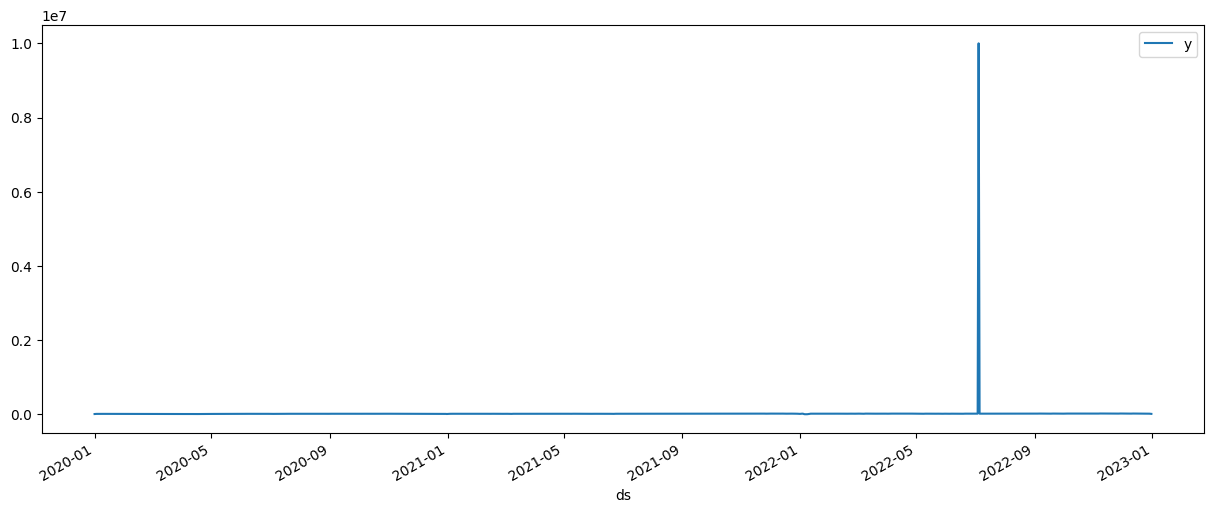

In [10]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [11]:
for i in range(2):
    data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()

C:\Users\lofas\AppData\Local\Temp\ipykernel_8848\1448882573.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22644.69708029197' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()


<Axes: xlabel='ds'>

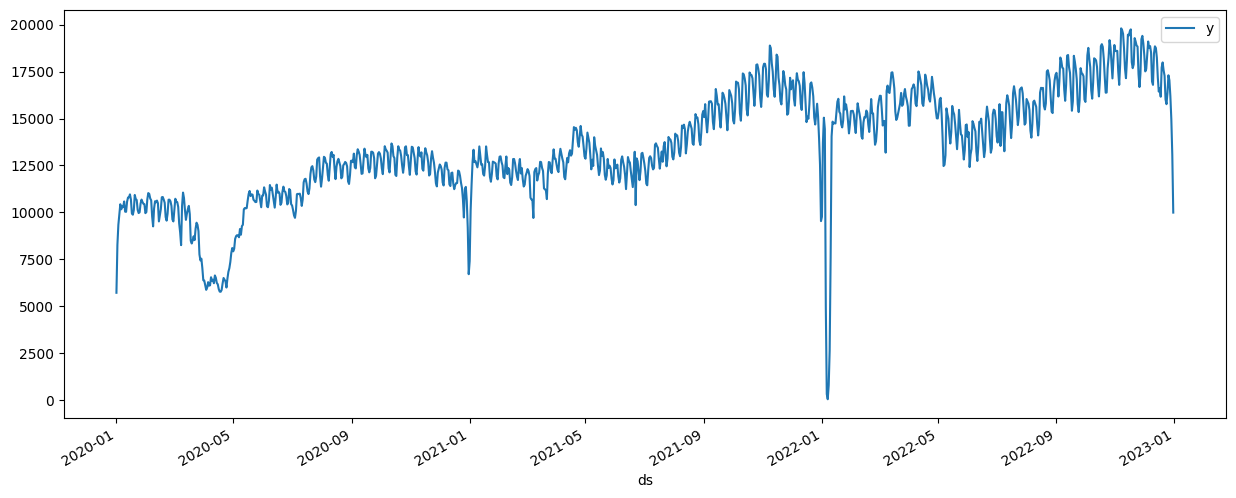

In [12]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [13]:
for i in range(5):
    data.loc[data['y'].idxmin(), 'y'] = data['y'].mean()

<Axes: xlabel='ds'>

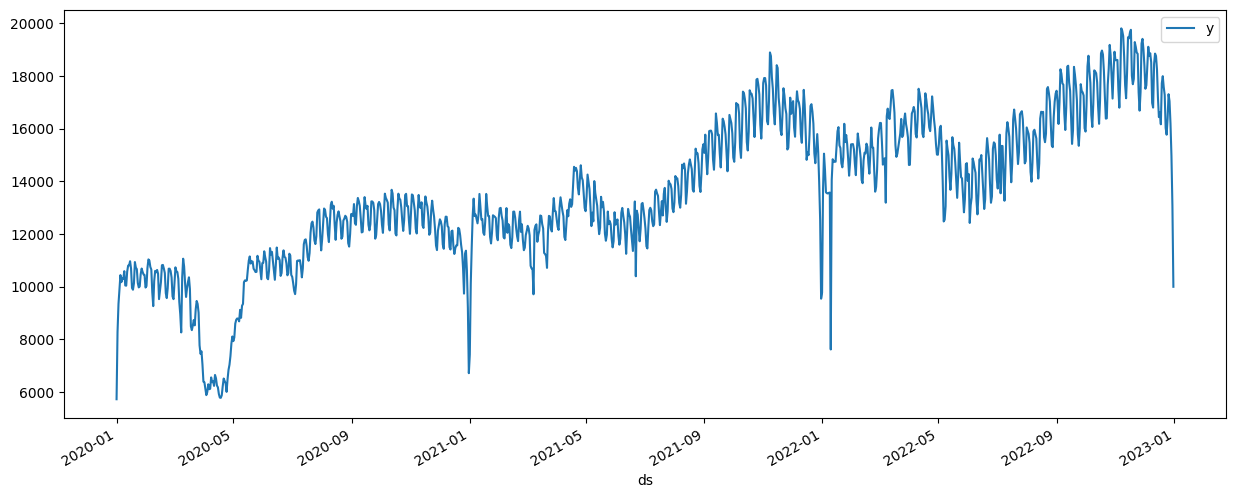

In [14]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [15]:
holidays_kz = holidays.KZ(years = (2020, 2021, 2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_kz, orient='index').rename(columns={0: 'holiday'})
df_holidays['ds'] = df_holidays.index
df_holidays.head()

,holiday,ds
2020-01-01,New Year,2020-01-01
2020-01-02,New Year,2020-01-02
2020-01-07,Orthodox Christmas,2020-01-07
2020-03-08,International Women's Day,2020-03-08
2020-03-22,Nauryz holiday,2020-03-22


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

class MyLinearRegression:
    def __init__(self, fit_intercept=True, lr=0.01, max_iter=100, sgd=False, n_sample=16):
        # основные параметры
        self.fit_intercept = fit_intercept
        self.w = None
        self.lr = lr
        self.max_iter = max_iter
        # параметры для стохастического градиентного спуска
        self.sgd = sgd
        self.n_sample = n_sample

    def fit(self, X, y):
        n, k = X.shape

        # случайно инициализируем веса
        if self.w is None:
            self.w = np.random.randn(k + 1 if self.fit_intercept else k)

        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X

        self.losses = []

        for iter_num in range(self.max_iter):
            y_pred = self.predict(X)
            self.losses.append(mean_squared_error(y_pred, y))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape == self.w.shape, f"gradient shape {grad.shape} is not equal weight shape {self.w.shape}"
            self.w -= self.lr * grad

        return self

    def _calc_gradient(self, X, y, y_pred):
        if self.sgd:
            inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)
            grad = 2 * (y_pred[inds] - y[inds])[:, np.newaxis] * X[inds]
            grad = grad.mean(axis=0)
        else:
            grad = 2 * (y_pred - y)[:, np.newaxis] * X
            grad = grad.mean(axis=0)
        return grad

    def get_losses(self):
        return self.losses

    def predict(self, X):
        n, k = X.shape
        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X  
        y_pred = X_train @ self.w
        return y_pred

    def get_weights(self):
        return self.w


MAE для обучающих данных: 13586.813547560398


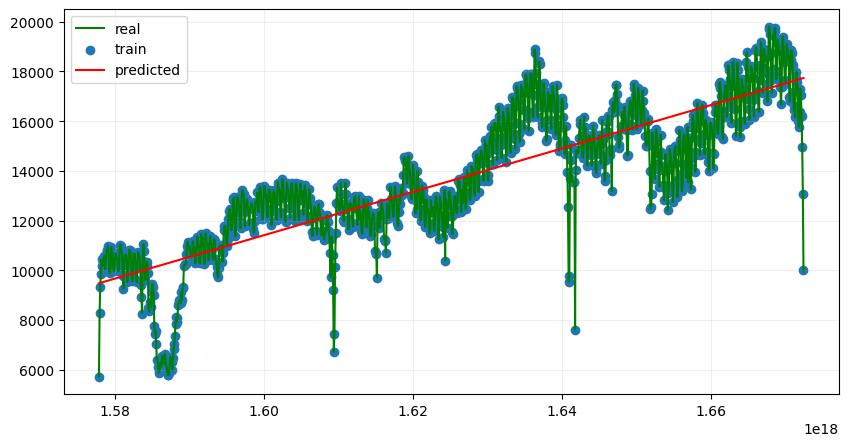

In [22]:

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Использование модели с DataFrame data и столбцами 'ds' и 'y'
regressor = MyLinearRegression(fit_intercept=True, lr=0.01, max_iter=100000, sgd=True, n_sample=90)

# Преобразование столбца 'ds' в числовой формат
data['ds'] = data['ds'].astype(np.int64)

# Использование столбцов 'ds' и 'y' для обучения
X = data['ds'].values.reshape(-1, 1)  # Преобразование в двумерный массив для совместимости с моделью
y = data['y'].values

# Нормализация данных
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
y_normalized = scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Обучение модели
l = regressor.fit(X_normalized, y_normalized).get_losses()

# Предсказание значений для тестовых данных (используем те же данные для тестирования)
predictions = regressor.predict(X_normalized)

# Получение весов модели
w = regressor.get_weights()

mae_train = mean_absolute_error(y, predictions)
print("MAE для обучающих данных:", mae_train)

# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(data['ds'], scaler.inverse_transform(y_normalized.reshape(-1, 1)), label='real', c='g')  # Используем 'ds' как ось X и 'y' как ось Y

plt.scatter(data['ds'], scaler.inverse_transform(y_normalized.reshape(-1, 1)), label='train')
plt.plot(data['ds'], scaler.inverse_transform(predictions.reshape(-1, 1)), label='predicted', c='r')  # Используем 'ds' для предсказаний

plt.grid(alpha=0.2)
plt.legend()
plt.show()




In [24]:
data_2023 = data.frame(ds = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D'))

data_2023['y'] = regressor.predict(scaler.transform(data_2023['ds'].values.reshape(-1, 1)))
data_2023['y'] = scaler.inverse_transform(data_2023['y'].values.reshape(-1, 1))
data_2023.head()

data_2023.plot(x = 'ds', y = 'y', figsize=(15, 6))


TypeError: DataFrame.__init__() got an unexpected keyword argument 'ds'